<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/intro/linreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear regression <a class="anchor" id="linreg"></a>

In this section, we illustrate how to perform linear regression using scikit-learn.


### Install necessary libraries

See [this notebook](https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/pyprobml_setup.ipynb) for detailed setup instructions.


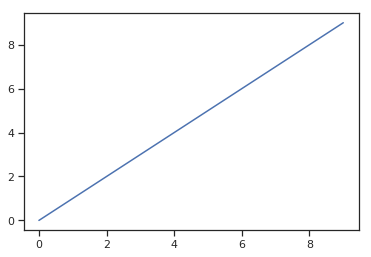

In [1]:
# Standard Python libraries
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

import sklearn

import seaborn as sns;
sns.set(style="ticks", color_codes=True)

import pandas as pd
pd.set_option('precision', 2) # 2 decimal places
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 100) # wide windows

# Check we can plot stuff
plt.figure()
plt.plot(range(10))

### Linear regression in 1d <a class="anchor" id="linreg-1d"></a>

In [0]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler 
import sklearn.metrics 
from sklearn.metrics import mean_squared_error as mse

def make_1dregression_data(n=21):
    np.random.seed(0)
    xtrain = np.linspace(0.0, 20, n)
    xtest = np.arange(0.0, 20, 0.1)
    sigma2 = 4
    w = np.array([-1.5, 1/9.])
    fun = lambda x: w[0]*x + w[1]*np.square(x)
    ytrain = fun(xtrain) + np.random.normal(0, 1, xtrain.shape) * \
        np.sqrt(sigma2)
    ytest= fun(xtest) + np.random.normal(0, 1, xtest.shape) * \
        np.sqrt(sigma2)
    return xtrain, ytrain, xtest, ytest

xtrain, ytrain, xtest, ytest = make_1dregression_data(n=21)

#Rescaling data
scaler = MinMaxScaler(feature_range=(-1, 1))
Xtrain = scaler.fit_transform(xtrain.reshape(-1, 1))
Xtest = scaler.transform(xtest.reshape(-1, 1))

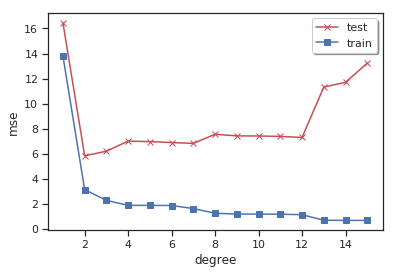

In [3]:
degs = np.arange(1, 21, 1)
ndegs = np.max(degs)
mse_train = np.empty(ndegs)
mse_test = np.empty(ndegs)
ytest_pred_stored = np.empty(ndegs, dtype=np.ndarray)
ytrain_pred_stored = np.empty(ndegs, dtype=np.ndarray)
for deg in degs:
    model = LinearRegression()
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    Xtrain_poly = poly_features.fit_transform(Xtrain)
    model.fit(Xtrain_poly, ytrain)
    ytrain_pred = model.predict(Xtrain_poly)
    ytrain_pred_stored[deg-1] = ytrain_pred
    Xtest_poly = poly_features.transform(Xtest)
    ytest_pred = model.predict(Xtest_poly)
    mse_train[deg-1] = mse(ytrain_pred, ytrain) 
    mse_test[deg-1] = mse(ytest_pred, ytest)
    ytest_pred_stored[deg-1] = ytest_pred
    
# Plot MSE vs degree
fig, ax = plt.subplots()
mask = degs <= 15
ax.plot(degs[mask], mse_test[mask], color = 'r', marker = 'x',label='test')
ax.plot(degs[mask], mse_train[mask], color='b', marker = 's', label='train')
ax.legend(loc='upper right', shadow=True)
plt.xlabel('degree')
plt.ylabel('mse')
#save_fig('polyfitVsDegree.pdf')
plt.show()



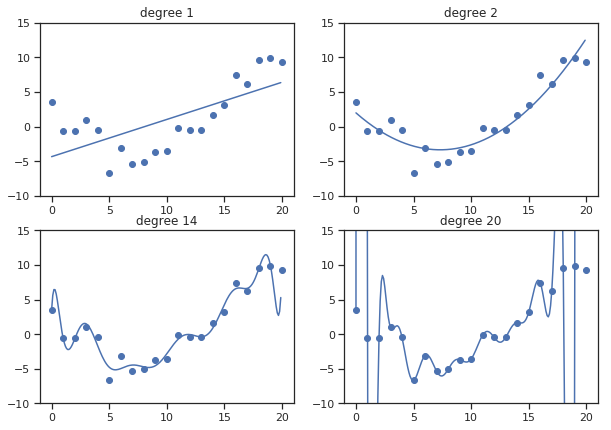

In [4]:
# Plot fitted functions
chosen_degs = [1, 2, 14, 20]
fig, axes = plt.subplots(2,2, figsize=(10,7))
axes = axes.reshape(-1)
for i, deg in enumerate(chosen_degs):
    #fig, ax = plt.subplots()
    ax = axes[i]
    ax.scatter(xtrain, ytrain)
    ax.plot(xtest, ytest_pred_stored[deg-1])
    ax.set_ylim((-10, 15))
    ax.set_title('degree {}'.format(deg))
    #save_fig('polyfitDegree{}.pdf'.format(deg))
plt.show()

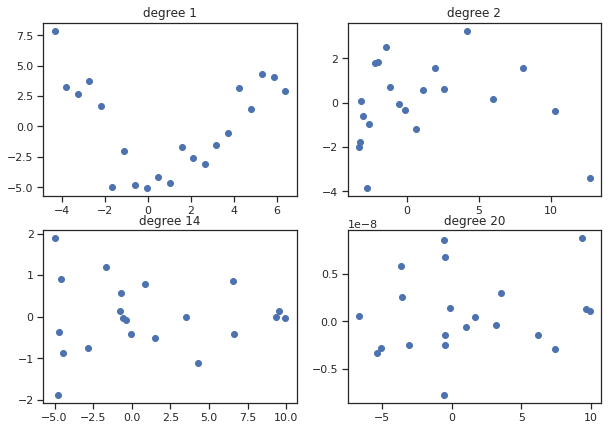

In [5]:
# Plot residuals
chosen_degs = [1, 2, 14, 20]
fig, axes = plt.subplots(2, 2, figsize=(10,7))
axes = axes.reshape(-1)
for i, deg in enumerate(chosen_degs):
    #fig, ax = plt.subplots(figsize=(3,2))
    ax = axes[i]
    ypred =  ytrain_pred_stored[deg-1]
    residuals = ytrain - ypred
    ax.plot(ypred, residuals, 'o')
    ax.set_title('degree {}'.format(deg))
    #save_fig('polyfitDegree{}Residuals.pdf'.format(deg))
plt.show()

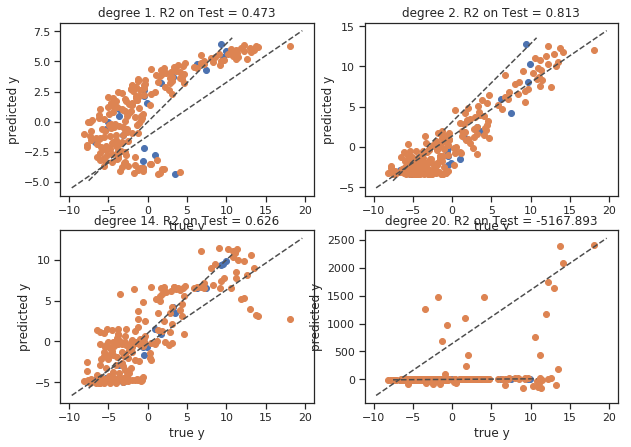

In [6]:
# Plot fit vs actual
chosen_degs = [1, 2, 14, 20]
fig, axes = plt.subplots(2,2, figsize=(10,7))
axes = axes.reshape(-1)
for i, deg in enumerate(chosen_degs):
    for train in [True, False]:
        if train:
            ytrue = ytrain
            ypred = ytrain_pred_stored[deg-1]
            dataset = 'Train'
        else:
            ytrue = ytest
            ypred = ytest_pred_stored[deg-1]
            dataset = 'Test'
        #fig, ax = plt.subplots()
        ax = axes[i]
        ax.scatter(ytrue, ypred)
        ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
        ax.set_xlabel('true y')
        ax.set_ylabel('predicted y')
        r2 = sklearn.metrics.r2_score(ytrue, ypred)
        ax.set_title('degree {}. R2 on {} = {:0.3f}'.format(deg, dataset, r2))
        #save_fig('polyfitDegree{}FitVsActual{}.pdf'.format(deg, dataset))
plt.show()

### Linear regression for boston housing <a class="anchor" id="linreg-boston"></a>

In [7]:
import sklearn.datasets
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split

boston = sklearn.datasets.load_boston()
X = boston.data
y = boston.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

scaler = sklearn.preprocessing.StandardScaler()
scaler = scaler.fit(X_train)
Xscaled = scaler.transform(X_train)
# equivalent to Xscaled = scaler.fit_transform(X_train)

# Fit model
linreg = lm.LinearRegression()
linreg.fit(Xscaled, y_train)

# Extract parameters
coef = np.append(linreg.coef_, linreg.intercept_)
names = np.append(boston.feature_names, 'intercept')
print(names)
print(coef)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT' 'intercept']
[-0.98858032  0.86793276  0.40502822  0.86183791 -1.90009974  2.80813518
 -0.35866856 -3.04553498  2.03276074 -1.36400909 -2.0825356   1.04125684
 -3.92628626 22.97079646]


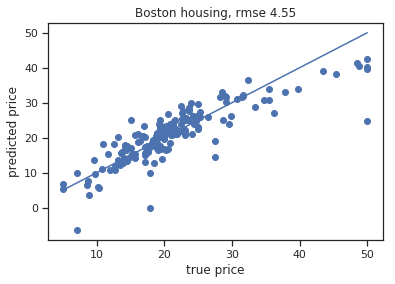

In [8]:
# Assess fit on test set
Xtest_scaled = scaler.transform(X_test)
ypred = linreg.predict(Xtest_scaled) 

plt.figure()
plt.scatter(y_test, ypred)
plt.xlabel("true price")
plt.ylabel("predicted price")
mse = sklearn.metrics.mean_squared_error(y_test, ypred)
plt.title("Boston housing, rmse {:.2f}".format(np.sqrt(mse)))
xs = np.linspace(min(y), max(y), 100)
plt.plot(xs, xs, '-')
#save_fig("boston-housing-predict.pdf")
plt.show()


## Ridge regression <a class="anchor" id="ridge"></a>

In this section, we illustrate how to perform ridge regression using scikit-learn.

In [0]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error as mse

xtrain, ytrain, xtest, ytest = make_1dregression_data(n=21)

#Rescaling data
scaler = MinMaxScaler(feature_range=(-1, 1))
Xtrain = scaler.fit_transform(xtrain.reshape(-1, 1))
Xtest = scaler.transform(xtest.reshape(-1, 1))

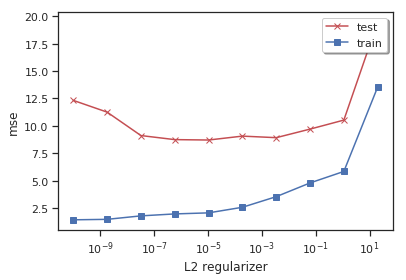

In [10]:
deg = 14
alphas = np.logspace(-10, 1.3, 10)
nalphas = len(alphas)
mse_train = np.empty(nalphas)
mse_test = np.empty(nalphas)
ytest_pred_stored = dict()
for i, alpha in enumerate(alphas):
    model = Ridge(alpha=alpha, fit_intercept=False)
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    Xtrain_poly = poly_features.fit_transform(Xtrain)
    model.fit(Xtrain_poly, ytrain)
    ytrain_pred = model.predict(Xtrain_poly)
    Xtest_poly = poly_features.transform(Xtest)
    ytest_pred = model.predict(Xtest_poly)
    mse_train[i] = mse(ytrain_pred, ytrain) 
    mse_test[i] = mse(ytest_pred, ytest)
    ytest_pred_stored[alpha] = ytest_pred
    
# Plot MSE vs degree
fig, ax = plt.subplots()
mask = [True]*nalphas
ax.plot(alphas[mask], mse_test[mask], color = 'r', marker = 'x',label='test')
ax.plot(alphas[mask], mse_train[mask], color='b', marker = 's', label='train')
ax.set_xscale('log')
ax.legend(loc='upper right', shadow=True)
plt.xlabel('L2 regularizer')
plt.ylabel('mse')
#save_fig('polyfitVsRidge.pdf')
plt.show()


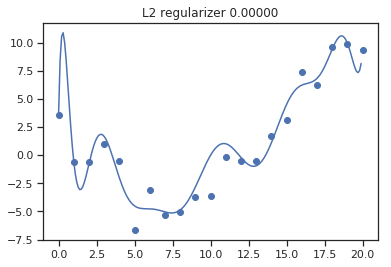

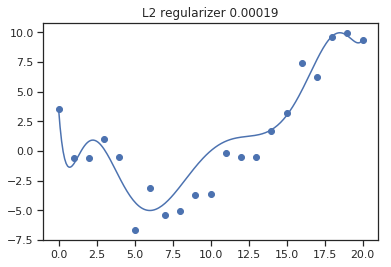

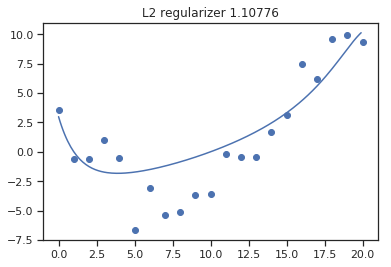

In [11]:
# Plot fitted functions
chosen_alphas = alphas[[0,5,8]]
for i, alpha in enumerate(chosen_alphas):
    fig, ax = plt.subplots()
    ax.scatter(xtrain, ytrain)
    ax.plot(xtest, ytest_pred_stored[alpha])
    plt.title('L2 regularizer {:0.5f}'.format(alpha))
    #save_fig('polyfitRidge{}.pdf'.format(i))
    plt.show()
    